In [1]:
import os
import random
from PIL import Image
import numpy as np
import mxnet as mx
import tqdm
import itertools
import logging
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv

/home/seventheli/anaconda3/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.1+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
from matplotlib import pyplot as plt
import cv2

In [3]:
import gym

In [32]:
# training cases
order = "model_test"
model_save = "./model_save/"
# batch size
image_size = 80
batch_size = 16
# agent view
agent_view = 5
map_size = 20
# action max
# learning rate
lr = 0.001
max_frame = 1000000
# start play
replay_start = 5000
# update step
online_update = 10000
# freq of 1/n step update the Q-network
update_step = 4
# skip n-1 raw frames between steps
skip_frame = 4 
# skip n-1 raw frames between skipped frames
internal_skip_frame = 4
# each state is formed as a concatination n step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 4
# eps
no_op_max = 10 / skip_frame
# gamma in q-loss calculation
gamma = 0.99
# memory pool size
memory_length = 20000
# file to save train log
summary = "./{}_Reward.csv".format(order)
eval_statistics = "./{}_CSV.csv".format(order)
# the number of step it take to linearly anneal the epsilon to it min value
annealing_end = 100000
max_frame = 200000000
# min level of stochastically of policy (epsilon)-greedy
epsilon_min = 0.1
# temporary files
temporary_model = "{}/{}.params".format(model_save, order)
temporary_pool = "{}/{}.pool".format(model_save, order)

In [5]:
logger = logging.getLogger()
f_name = "./data/results_DDQN.log"
fh = logging.handlers.RotatingFileHandler(f_name)
fh.setLevel(logging.DEBUG)#no matter what level I set here
formatter = logging.Formatter("%(asctime)s:%(message)s")

In [6]:
if os.path.exists(summary):
    os.remove(summary)
ctx = mx.gpu()
for i in ["model_save", "data_save"]:
    check_dir(i)
# create env
env_name = "AssaultNoFrameskip-v4"
env = gym.make(env_name)
memory_pool = Memory(memory_length)

In [7]:
# build models
from model.simple_stack import SimpleStack
online_model = SimpleStack(env.action_space.n)
offline_model = SimpleStack(env.action_space.n)
online_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().zero_grad()

In [8]:

annealing = 0
total_reward = np.zeros(num_episode)
loss_func = gluon.loss.L2Loss()
gamma1 = 0.95 # RMSprop gamma1
gamma2 = 0.95 # RMSprop gamma2
rms_eps = 0.01 # RMSprop epsilon bias
trainer = gluon.Trainer(offline_model.collect_params(), 'RMSProp',  
                        {'learning_rate': lr, "epsilon": rms_eps, "gamma1": gamma1, "gamma2": gamma2, "centered" : True})

In [9]:
def preprocess(raw_frame, image_size, live, frame_len, current_state = None, initial_state = False):
    raw_frame = nd.array(cv2.resize(raw_frame, (image_size,image_size)))
    # remove color
    # raw_frame = nd.reshape(nd.mean(raw_frame, axis = 2),shape = (raw_frame.shape[0],raw_frame.shape[1],1))
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = raw_frame.astype(np.float32)/255.
    if initial_state == True:
        state = raw_frame
        for _ in range(frame_len-1):
            state = nd.concat(state , raw_frame, dim = 0)
    else:
        # state = mx.nd.concat(current_state[0][1:,:,:], raw_frame, dim = 0)
        state = mx.nd.concat(current_state[0][3:,:,:], raw_frame, dim = 0)
    return state, nd.array([live["lives"]])

def rew_clipper(rew):
    if rew>0.:
        return 1.
    elif rew<0.:
        return -1.
    else:
        return 0

def renderimage(next_frame):
    if render_image:
        plt.imshow(next_frame);
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

In [10]:
def replace_parameters(ctx):
    offline_model.save_parameters(temporary_model)
    online_model.load_parameters(temporary_model, ctx)

In [11]:
def save_parameters():
    offline_model.save_parameters("offline.parameters")
    online_model.save_parameters("online.parameters")

In [12]:
def load_parameters():
    offline_model.load_parameters("offline.parameters")
    online_model.load_parameters("online.parameters")

In [13]:
print_structure = 0
frame_counter = 0
annealing_count = 0

render_image = False

In [14]:
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
moving_average_clipped = 0.
moving_average = 0.

In [ ]:
batch_state = nd.empty((batch_size,frame_len,image_size,image_size), ctx)
batch_state_next = nd.empty((batch_size,frame_len,image_size,image_size), ctx)

In [ ]:
frame_counter = 0
epoch = 0

In [33]:
while frame_counter < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    live = {'lives': 5}
    state = preprocess(next_frame,image_size, live, frame_len, initial_state=True)
    t = 0
    done = False
    if print_structure == 1:
        print("Model Structure: ")
        print(offline_model)
        print_structure += 1
    while not done:
        previous_state = state
        # show the frame
        renderimage(next_frame)
        if frame_counter > replay_start:
            annealing_count += 1
        if frame_counter == replay_start:
            logging.info('annealing and laerning are started ')
        eps = np.maximum(1.-annealing_count/annealing_end, epsilon_min)
        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        # epsilon greedy policy
        if np.random.random() < effective_eps :
            by = "Random"
            action = np.random.randint(0, (env.action_space.n))
        else:
            by = "Model"
            data = [i.reshape([1]+list(i.shape)).as_in_context(ctx) for i in state]
            output = offline_model(data)
            action = int(nd.argmax(output,axis=1).as_in_context(mx.cpu()).asscalar())
            print_structure += 1
        # skip frame
        rew = 0
        for skip in range(skip_frame-1):
            next_frame, reward, done, _ = env.step(action)
            state = preprocess(next_frame,image_size, _, frame_len, initial_state=True)
            renderimage(next_frame)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
            for internal_skip in range(internal_skip_frame-1):
                _ , reward, done,_ = env.step(action)
                cum_clipped_reward += rew_clipper(reward)
                rew += reward
        next_frame_new, reward, done, _ = env.step(action)
        renderimage(next_frame)
        cum_clipped_reward += rew_clipper(reward)
        rew += reward
        cum_reward += rew
        # reward clipping
        reward = rew_clipper(rew)
        next_frame = np.maximum(next_frame_new,next_frame)
        state = preprocess(next_frame, image_size, _, frame_len, state, False)
        _previous_state = [(previous_state[0]*255.).astype('uint8'), previous_state[1]]
        _state = [(state[0]*255.).astype('uint8'), state[1]]
        memory_pool.add(_previous_state, _state, action, reward, int(done))
        # train
        if frame_counter > replay_start:
            # sample random mini batch of transitions
            if len(memory_pool.memory) > batch_size:
                bz = batch_size
            else:
                bz = len(memory_pool.memory)
            transitions = memory_pool.next_batch(bz)
            batch_state = transitions["state"]
            batch_state[0] = (batch_state[0].astype('float32')/255.).as_in_context(ctx)
            batch_state[1] = batch_state[1].as_in_context(ctx)
            batch_state_next = transitions["state_next"]
            batch_state_next[0] = (batch_state_next[0].astype('float32')/255.).as_in_context(ctx)
            batch_state_next[1] = batch_state_next[1].as_in_context(ctx)
            batch_reward = nd.array(transitions["reward"],ctx)
            batch_action = nd.array(transitions["action"],ctx).astype('uint8')
            batch_done = nd.array(transitions["finish"],ctx)
            with autograd.record():
                argmax_Q = nd.argmax(offline_model(batch_state_next),axis = 1).astype('uint8')
                Q_sp = nd.pick(online_model(batch_state_next),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(bz,ctx= ctx)-batch_done)
                Q_s_array = offline_model(batch_state)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_func(Q_s ,(batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(bz)
        t += 1
        frame_counter += 1
        # save the offline model and update Target model
        if frame_counter > replay_start:
            if frame_counter % online_update == 0 :
                check_point = frame_counter / (online_update *100)
                offline_model.save_parameters(temporary_model)
                online_model.load_parameters(temporary_model, ctx)
                fnam = './data/clippted_rew_DDQN_%s' %(env_name)
                np.save(fnam,tot_clipped_reward)
                fnam = './data/tot_rew_DDQN_%s' %(env_name)
                np.save(fnam,tot_reward)
                fnam = './data/frame_count_DDQN_%s' %(env_name)
                np.save(fnam,frame_count_record)
        if done:
            if epoch % 10. == 0. :
                print('epis[%d],eps[%f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %d,tot_cl = %d , tot = %d'\
                  %(epoch,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average))
        frame_counter += 1
    epoch += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epoch > 100:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epoch)-1-100:int(epoch)-1])
        moving_average = np.mean(tot_reward[int(epoch)-1-100:int(epoch)-1])

MXNetError: Traceback (most recent call last):
  File "../src/operator/nn/concat.cc", line 67
MXNetError: Check failed: shape_assign(&(*in_shape)[i], dshape): Incompatible input shape: expected [-1,12,84,84], got [1,12,80,80]

In [16]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, moving_average_clipped)

Running after 777 number of episodes


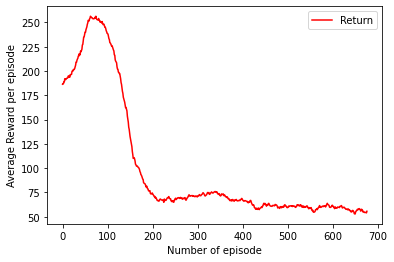

In [34]:
num_epis_count = epoch-0
bandwidth = 100 # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count)-bandwidth)
total_rew = np.zeros(int(num_epis_count)-bandwidth)
for i in range(int(num_epis_count)-bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i+bandwidth])/bandwidth
    total_rew[i] = np.sum(tot_reward[i:i+bandwidth])/bandwidth
t = np.arange(int(num_epis_count)-bandwidth)
fig = plt.figure()
belplt = plt.plot(t,total_rew[0:int(num_epis_count)-bandwidth],"r", label = "Return")
plt.legend()#handles[likplt,belplt])
print('Running after %d number of episodes' %epoch)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('DDQN.png')

In [18]:
from IPython import display
import time